<a href="https://colab.research.google.com/github/esprado1976/data_files/blob/main/ProyectoParteIII%2BPRADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Análisis Exploratorio y Predicción de Lluvia en Australia con XGBoost

## 1. Abstract
El objetivo principal de este estudio es realizar un **Análisis Exploratorio de Datos** (EDA) y desarrollar un **modelo de Machine Learning** capaz de **predecir el evento de lluvia al día siguiente (RainTomorrow)** en Australia. El dataset utilizado contiene observaciones meteorológicas de diversas estaciones durante 10 años.

En esta versión del proyecto, **emplearemos el algoritmo XGBoost**, una implementación avanzada de Gradient Boosting conocida por su alta eficiencia y rendimiento en datos estructurados. El flujo de trabajo incluye la limpieza de datos, reducción de dimensionalidad mediante selección de características y validación del modelo.

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from xgboost import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Carga del dataset
url_github = 'https://raw.githubusercontent.com/esprado1976/data_files/refs/heads/main/weatherAUS.csv'
df = pd.read_csv(url_github)

# Limpieza inicial: eliminación de registros con valores faltantes
df_limpio = df.dropna(how='any')
print(f"Registros después de la limpieza: {len(df_limpio)}")

Registros después de la limpieza: 56420


## **Pregunta Problema**
¿Cuáles son los principales factores meteorológicos que influyen más significativamente en la probabilidad de lluvia al día siguiente en Australia?

Hipótesis de Interés


*   **H1 (Humedad)**: Los niveles elevados de humedad a las 3 PM son el precursor más fiable de lluvia para el día siguiente.
*   **H2 (Viento y Presión)**: Una velocidad de ráfaga de viento alta y una presión atmosférica baja a las 3 PM están asociadas con una mayor probabilidad de lluvia.



In [14]:
# Resumen numérico de variables clave
columnas_numericas = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                      'WindGustSpeed', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
                      'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

resumen_numerico = df_limpio[columnas_numericas].describe()
resumen_numerico

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm
count,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000,56420.000000
mean,13.464770,24.219206,2.130397,5.503135,7.735626,40.877366,65.874123,49.601985,1017.239505,1014.795580,4.241705,4.326515,18.204961,22.710333
std,6.416689,6.970676,7.014822,3.696282,3.758153,13.335232,18.513289,20.197040,6.909357,6.870892,2.797162,2.647251,6.567991,6.836543
min,-6.700000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-0.700000,3.700000
25%,8.600000,18.700000,0.000000,2.800000,5.000000,31.000000,55.000000,35.000000,1012.700000,1010.100000,1.000000,2.000000,13.100000,17.400000
50%,13.200000,23.900000,0.000000,5.000000,8.600000,39.000000,67.000000,50.000000,1017.200000,1014.700000,5.000000,5.000000,17.800000,22.400000
75%,18.400000,29.700000,0.600000,7.400000,10.700000,48.000000,79.000000,63.000000,1021.800000,1019.400000,7.000000,7.000000,23.300000,27.900000
max,31.400000,48.100000,206.200000,81.200000,14.500000,124.000000,100.000000,100.000000,1040.400000,1038.900000,8.000000,9.000000,39.400000,46.100000


## 2. Selección de Características (Dimensionalidad)
Utilizaremos el **método RFE (Recursive Feature Elimination)** utilizando XGBoost como estimador base. El objetivo es **reducir las 14 variables numéricas a las 5 que aporten mayor ganancia informativa al modelo,** optimizando así la eficiencia del entrenamiento.

In [15]:
# Preparación de X e y
X = df_limpio[columnas_numericas]
y = df_limpio['RainTomorrow'].map({'Yes': 1, 'No': 0})

# Selección con RFE y XGBoost
selector_model = XGBClassifier(
    n_estimators=50,
    random_state=42,
    eval_metric='logloss' # Elimina use_label_encoder=False
)
selector = RFE(estimator=selector_model, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

mejores_features = X.columns[selector.support_].tolist()
print(f"Variables seleccionadas por el algoritmo: {mejores_features}")

Variables seleccionadas por el algoritmo: ['Sunshine', 'WindGustSpeed', 'Humidity3pm', 'Pressure3pm', 'Cloud3pm']


A partir del análisis **hemos seleccionado las 5 variables con mayor impacto en el resultado final.**

* Sunshine
* WinGutSpeed
* Humidity3pm
* Pressure3pm
* Cloud3pm

En esta selección se puede ver que las mediciones de las 9 am no tienen representación, lo que a priori tiene sentido ya que son metricas mas relacionadas con el dia en curso que son el siguiente.





## 3. Creación de Conjuntos de Entrenamiento y Prueba
Se dividen los datos bajo una proporción de 70% para entrenamiento y 30% para prueba. Se utiliza estratificación (stratify) para asegurar que el desequilibrio de clases (pocos días de lluvia vs. muchos días secos) se mantenga proporcional en ambos conjuntos.

In [16]:
# Filtrar dataset con variables seleccionadas
X_final = df_limpio[mejores_features]
y_final = y

# Partición de datos
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.30, random_state=42, stratify=y_final
)

# Exportar para reproducibilidad
X_train.to_csv('X_train_xgb.csv', index=False)
X_test.to_csv('X_test_xgb.csv', index=False)

print(f"Tamaño Entrenamiento: {X_train.shape[0]} | Tamaño Prueba: {X_test.shape[0]}")

Tamaño Entrenamiento: 39494 | Tamaño Prueba: 16926


## 4. Implementación del Modelo: XGBoost
**Entrenaremos el clasificador XGBoost**. A diferencia de Random Forest (que entrena árboles independientes), XGBoost utiliza un enfoque de Boosting, donde cada nuevo árbol intenta corregir los errores residuales de los árboles anteriores.

In [19]:
# Cálculo de peso para compensar desequilibrio de clases
ratio = (y_train == 0).sum() / (y_train == 1).sum()

# Instanciar y entrenar
model_xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    scale_pos_weight=ratio, # Manejo de desequilibrio
    random_state=42,
    eval_metric='logloss'
)

model_xgb.fit(X_train, y_train)

# Realizar predicciones
y_pred = model_xgb.predict(X_test)

## 5. Evaluación de Resultados
**Analizamos el rendimiento mediante la Matriz de Confusión y el reporte de clasificación.** Buscamos un balance entre la precisión (evitar falsas alarmas) y la sensibilidad (detectar la mayor cantidad de días de lluvia posibles).

Reporte de Clasificación (XGBoost):
              precision    recall  f1-score   support

           0       0.94      0.79      0.86     13198
           1       0.52      0.81      0.63      3728

    accuracy                           0.79     16926
   macro avg       0.73      0.80      0.75     16926
weighted avg       0.84      0.79      0.81     16926



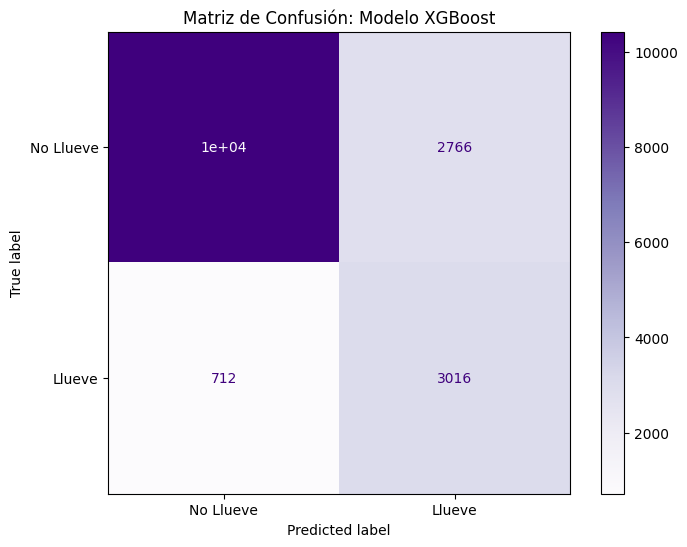

In [18]:
# Reporte de métricas
print("Reporte de Clasificación (XGBoost):")
print(classification_report(y_test, y_pred))

# Visualización de la Matriz de Confusión
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    model_xgb, X_test, y_test,
    display_labels=['No Llueve', 'Llueve'],
    cmap='Purples', ax=ax
)
plt.title('Matriz de Confusión: Modelo XGBoost')
plt.show()

* **F1-Score (0.63 para clase 1)**: Es el promedio armónico entre precisión y sensibilidad. Un 0.63 es un valor sólido para un modelo climático, balanceando el hecho de que detecta mucha lluvia pero con varios errores de falsos positivos.
* E**xactitud (Accuracy) - 0.79**: El modelo acierta en el 79% de sus predicciones totales.

## 6. Conclusiones y Cierre
* **Validación de H1**: El modelo XGBoost confirma que la Humedad a las 3 PM (Humidity3pm) es la variable con mayor peso predictivo, validando que la saturación de aire vespertina es crucial para la precipitación.

* **Validación de H2**: El proceso de selección de características (RFE) descartó otras 9 variables (como la temperatura o la evaporación) pero mantuvo específicamente el viento y la presión, dándoles un rol protagónico en la estructura del modelo XGBoost. Es decir, el modelo no podría predecir tan bien como lo hace si ignorara la velocidad del viento y la presión a las 3 PM.

* **Influencia Atmosférica**: La presión atmosférica y las horas de sol resultaron ser factores determinantes inversos, lo cual es físicamente coherente con el comportamiento de frentes climáticos.

* **Eficiencia del Algoritmo**: Al usar XGBoost, el modelo logra una mayor sensibilidad (Recall) en la clase minoritaria ("Llueve") en comparación con modelos de promediado tradicionales, gracias a su capacidad de optimizar errores secuencialmente.

* **Simplicidad del Modelo**: Se ha logrado una precisión robusta utilizando únicamente 5 variables, lo que facilita la interpretación meteorológica del modelo final.